# Authors:
##### Maria Musiał : 156062
##### Joanna Szczublińska : 156xxx
##### Wiktoria Szarzyńska : 156xxx

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
import torch
import torchvision.models as models
import PIL.Image
import string
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import cv2
from torchvision.transforms.functional import to_pil_image

In [8]:
class ApplyCLAHE:
    """
    Konwersja RGB → YUV, zastosowanie CLAHE na kanale Y, powrót do RGB.
    """
    def __init__(self, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img: PIL.Image.Image) -> PIL.Image.Image:
        # Konwersja PIL.Image → numpy (RGB, uint8)
        img_np = np.array(img)
        # RGB → YUV
        img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)
        # CLAHE na kanale Y
        y_channel = img_yuv[:, :, 0]
        img_yuv[:, :, 0] = self.clahe.apply(y_channel)
        # YUV → RGB
        img_rgb_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return PIL.Image.fromarray(img_rgb_eq)

### Defining dataset class

In [9]:
# root_dir = "put_jetbot_dataset/dataset/"
# samples=[]


class JetBotDataset(Dataset):
    """
    Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
    Returns image(rgb), [forward, left] tensor
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        folders = [name for name in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, name))]

        for folder_name in folders:
            file_name = folder_name + ".csv"
            csv_path = os.path.join(root_dir, file_name)
            folder_path = os.path.join(root_dir, folder_name)
            # print(folder_name, file_name, csv_path, folder_path)

            if not os.path.exists(csv_path):
                print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
                continue
            
            try:
                df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
                df.columns = ["filename", "forward", "left"]

                for _, row in df.iterrows():
                    img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
                    if not os.path.exists(img_path):
                        print(f"Warnign: Image file {img_path} not found.")
                        continue
                    self.samples.append((img_path, float(row["forward"]), float(row["left"])))
            except Exception as e:
                print(f"Error processing {csv_path}: e")
                
        print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, forward, left = self.samples[idx]
        
        try:
            image = PIL.Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor([forward, left], dtype=torch.float32)
            # return image, torch.tensor([forward, left], dtype=torch.float32)    

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3,224,224))
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    
#
from torchvision import transforms

def get_transforms(augument=True):
    """Create transformations for training and validation/test datasets.
    For JetBot camera images (usually 224x224 RGB).
    
    Args:
        augment (bool): If True, apply data augmentation for training.
        
    Returns:
        torchvision.transforms.Compose object
    """
    common_transforms = [
        ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
        transforms.Resize((224, 224)),  # resize all images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet normalization
                             std=[0.229, 0.224, 0.225]),
    ]

    if augument:
        train_transforms = [
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
            transforms.RandomRotation(degrees=2),
            # transforms.RandomHorizontalFlip(p=0.5),

            # Optional realistic distortions:
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),  # Simulate camera blur
            # transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Simulate lens distortion
            # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),  # Subtle motion

            *common_transforms
        ]
        return transforms.Compose( train_transforms)
    else:
        return transforms.Compose( common_transforms)


In [10]:
from torch.utils.data import Dataset

class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, target = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.subset)


In [11]:
from torch.utils.data import random_split, DataLoader

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    # Transforms
    train_transform = get_transforms(augument=True)
    val_test_transform = get_transforms(augument=False)

    # Load full dataset
    base_dataset = JetBotDataset(root_dir, transform=None)
    total_size = len(base_dataset)

    train_len = int(total_size * train_ratio)
    val_len = int(total_size * val_ratio)
    test_len = total_size - train_len - val_len

    generator = torch.Generator().manual_seed(42)
    train_base, val_base, test_base = random_split(base_dataset, [train_len, val_len, test_len], generator=generator)

    # Wrap with transforms
    train_set = SubsetWithTransform(train_base, transform=train_transform)
    val_set = SubsetWithTransform(val_base, transform=val_test_transform)
    test_set = SubsetWithTransform(test_base, transform=val_test_transform)

    return {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size),
        "test": DataLoader(test_set, batch_size=batch_size)
    }



In [12]:
data = create_datasets(root_dir = "put_jetbot_dataset/dataset/", batch_size=32)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]

Loaded 7584 samples from 13 folders


In [13]:
import matplotlib.pyplot as plt
import torchvision

# Reverse normalization: ImageNet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def unnormalize(tensor):
    for t, m, s in zip(tensor, imagenet_mean, imagenet_std):
        t.mul_(s).add_(m)
    return tensor


def show_batch(loader, n_images=8):
    batch = next(iter(loader))  # Get one batch
    images, labels = batch

    images = images[:n_images]  # limit to first N
    labels = labels[:n_images]

    # Unnormalize
    images = torch.stack([unnormalize(img.clone()) for img in images])

    # Create grid
    grid_img = torchvision.utils.make_grid(images, nrow=4)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Training Batch (Augmented + Normalized)")
    plt.axis("off")
    plt.show()

    # Optional: print labels (steering + throttle)
    for i, (fwd, left) in enumerate(labels):
        print(f"Sample {i}: forward = {fwd:.2f}, left = {left:.2f}")



In [14]:
# show_batch(train_loader)


In [15]:
# def count_control_classes(data_loader):
#     left_count = 0
#     straight_count = 0
#     right_count = 0

#     for images, labels in data_loader:
#         # labels[:, 1] is the "left" value (since [forward, left])
#         left_values = labels[:, 1]

#         left_count += (left_values < 0).sum().item()
#         straight_count += (left_values == 0).sum().item()
#         right_count += (left_values > 0).sum().item()

#     total = left_count + straight_count + right_count
#     print(f"Total samples: {total}")
#     print(f"Left (< 0): {left_count}")
#     print(f"Straight (= 0): {straight_count}")
#     print(f"Right (> 0): {right_count}")


In [16]:
# count_control_classes(train_loader)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class ModifiedNvidiaNetwork(nn.Module):
    def __init__(self):
        super(ModifiedNvidiaNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))  # Add adaptive pooling

        feature_size = 128 * 4 * 4  # matches avgpool output

        self.fc1 = nn.Linear(feature_size, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.avgpool(x)  # ensure fixed spatial size

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.output(x)

        return x


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model = NvidiaPaperNetwork().to(device)
model = ModifiedNvidiaNetwork().to(device)

Using device: cpu


In [19]:
print("\nModel architecture:")
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")



Model architecture:
ModifiedNvidiaNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 365,442


In [ ]:
    def weighted_mse_loss(pred, target):
        # Weight is higher for target values further from 0
        # You can tune the exponent (e.g., 2 or 3) to adjust steepness
        weights = 1.0 + (target.abs() ** 2)  # e.g., 1 + |target|^2

        mse = (pred - target) ** 2
        weighted_mse = weights * mse
        return weighted_mse.mean()


In [21]:
def training(model, train_loader, val_loader, device, weighted_mse_loss, epochs=100):
    """
    Training loop with model saving
    """
    best_model_path = 'best_model_jetbot.pth'
    best_loss = 1e9
    patience = 17
    patience_counter = 0    
    
    optimizer = optim.Adam(model.parameters(), lr =0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        model.train()
        train_loss = 0.0
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, targets in train_iterator:
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = weighted_mse_loss(outputs, targets)
            
            train_loss += float(loss)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_iterator.set_postfix(loss=float(loss))
            
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
            for images, targets in val_iterator:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                loss = weighted_mse_loss(outputs, targets)      
                val_loss += float(loss)
                
                # Update progress bar
                val_iterator.set_postfix(loss=float(loss))
                
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            torch.save(model.state_dict(), best_model_path)
            best_loss = val_loss
            patience_counter = 0
            print(f"New best model saved with val loss: {val_loss:.6f}")
        else:
            patience_counter += 1
            
    print(f"Training completed. Best val loss: {best_loss:.6f}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return best_model_path

Epoch 1/100 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 1/100 [Test]: 100%|██████████| 36/36 [00:13<00:00,  2.70it/s, loss=0.28] 


Epoch 1/100 - Train loss: 0.486327 - Val loss: 0.352518
New best model saved with val loss: 0.352518


Epoch 2/100 [Test]: 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, loss=0.227] 


Epoch 2/100 - Train loss: 0.249057 - Val loss: 0.183036
New best model saved with val loss: 0.183036


Epoch 3/100 [Test]: 100%|██████████| 36/36 [00:10<00:00,  3.29it/s, loss=0.207] 


Epoch 3/100 - Train loss: 0.202780 - Val loss: 0.173176
New best model saved with val loss: 0.173176


Epoch 4/100 [Test]: 100%|██████████| 36/36 [00:13<00:00,  2.69it/s, loss=0.206] 


Epoch 4/100 - Train loss: 0.188209 - Val loss: 0.168329
New best model saved with val loss: 0.168329


Epoch 5/100 [Test]: 100%|██████████| 36/36 [00:13<00:00,  2.69it/s, loss=0.182] 


Epoch 5/100 - Train loss: 0.176507 - Val loss: 0.167911
New best model saved with val loss: 0.167911


Epoch 6/100 [Test]: 100%|██████████| 36/36 [00:13<00:00,  2.73it/s, loss=0.211]


Epoch 6/100 - Train loss: 0.171083 - Val loss: 0.193626


Epoch 7/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.35it/s, loss=0.196] 


Epoch 7/100 - Train loss: 0.164648 - Val loss: 0.185304


Epoch 8/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.84it/s, loss=0.188] 


Epoch 8/100 - Train loss: 0.161649 - Val loss: 0.174716


Epoch 9/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.20it/s, loss=0.199] 


Epoch 9/100 - Train loss: 0.157388 - Val loss: 0.184886


Epoch 10/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.79it/s, loss=0.195] 


Epoch 10/100 - Train loss: 0.153399 - Val loss: 0.172592


Epoch 11/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.66it/s, loss=0.177] 


Epoch 11/100 - Train loss: 0.151407 - Val loss: 0.174139


Epoch 12/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.81it/s, loss=0.181] 


Epoch 12/100 - Train loss: 0.147557 - Val loss: 0.187582


Epoch 13/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.76it/s, loss=0.194] 


Epoch 13/100 - Train loss: 0.145178 - Val loss: 0.156023
New best model saved with val loss: 0.156023


Epoch 14/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.79it/s, loss=0.191] 


Epoch 14/100 - Train loss: 0.142879 - Val loss: 0.167372


Epoch 15/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.77it/s, loss=0.166] 


Epoch 15/100 - Train loss: 0.142910 - Val loss: 0.158862


Epoch 16/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.79it/s, loss=0.186] 


Epoch 16/100 - Train loss: 0.139016 - Val loss: 0.149329
New best model saved with val loss: 0.149329


Epoch 17/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.59it/s, loss=0.193] 


Epoch 17/100 - Train loss: 0.136245 - Val loss: 0.160209


Epoch 18/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.72it/s, loss=0.187] 


Epoch 18/100 - Train loss: 0.134430 - Val loss: 0.175934


Epoch 19/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s, loss=0.173] 


Epoch 19/100 - Train loss: 0.133150 - Val loss: 0.157433


Epoch 20/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.54it/s, loss=0.178] 


Epoch 20/100 - Train loss: 0.133054 - Val loss: 0.167275


Epoch 21/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.45it/s, loss=0.173] 


Epoch 21/100 - Train loss: 0.129550 - Val loss: 0.157817


Epoch 22/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.04it/s, loss=0.169] 


Epoch 22/100 - Train loss: 0.126927 - Val loss: 0.162205


Epoch 23/100 [Test]: 100%|██████████| 36/36 [00:09<00:00,  3.82it/s, loss=0.173] 


Epoch 23/100 - Train loss: 0.127106 - Val loss: 0.147321
New best model saved with val loss: 0.147321


Epoch 24/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.51it/s, loss=0.162] 


Epoch 24/100 - Train loss: 0.124947 - Val loss: 0.170238


Epoch 25/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.44it/s, loss=0.175] 


Epoch 25/100 - Train loss: 0.122012 - Val loss: 0.146095
New best model saved with val loss: 0.146095


Epoch 26/100 [Test]: 100%|██████████| 36/36 [00:09<00:00,  3.73it/s, loss=0.177] 


Epoch 26/100 - Train loss: 0.119576 - Val loss: 0.158720


Epoch 27/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.56it/s, loss=0.162] 


Epoch 27/100 - Train loss: 0.119739 - Val loss: 0.168747


Epoch 28/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.77it/s, loss=0.149] 


Epoch 28/100 - Train loss: 0.119099 - Val loss: 0.154303


Epoch 29/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.70it/s, loss=0.163] 


Epoch 29/100 - Train loss: 0.119407 - Val loss: 0.156500


Epoch 30/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.11it/s, loss=0.148] 


Epoch 30/100 - Train loss: 0.116035 - Val loss: 0.159642


Epoch 31/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.20it/s, loss=0.152] 


Epoch 31/100 - Train loss: 0.114558 - Val loss: 0.159788


Epoch 32/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.03it/s, loss=0.167] 


Epoch 32/100 - Train loss: 0.114634 - Val loss: 0.155248


Epoch 33/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.16it/s, loss=0.159] 


Epoch 33/100 - Train loss: 0.112544 - Val loss: 0.150379


Epoch 34/100 [Test]: 100%|██████████| 36/36 [00:10<00:00,  3.58it/s, loss=0.164] 


Epoch 34/100 - Train loss: 0.111960 - Val loss: 0.154278


Epoch 35/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.29it/s, loss=0.152] 


Epoch 35/100 - Train loss: 0.111399 - Val loss: 0.159582


Epoch 36/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.40it/s, loss=0.153] 


Epoch 36/100 - Train loss: 0.109932 - Val loss: 0.149005


Epoch 37/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s, loss=0.152] 


Epoch 37/100 - Train loss: 0.110915 - Val loss: 0.152863


Epoch 38/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.62it/s, loss=0.145] 


Epoch 38/100 - Train loss: 0.106832 - Val loss: 0.153065


Epoch 39/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.62it/s, loss=0.149] 


Epoch 39/100 - Train loss: 0.107184 - Val loss: 0.139953
New best model saved with val loss: 0.139953


Epoch 40/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.73it/s, loss=0.149] 


Epoch 40/100 - Train loss: 0.107344 - Val loss: 0.148651


Epoch 41/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.65it/s, loss=0.153] 


Epoch 41/100 - Train loss: 0.102912 - Val loss: 0.159681


Epoch 42/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.79it/s, loss=0.144] 


Epoch 42/100 - Train loss: 0.102149 - Val loss: 0.152364


Epoch 43/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.67it/s, loss=0.152] 


Epoch 43/100 - Train loss: 0.101454 - Val loss: 0.148478


Epoch 44/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.72it/s, loss=0.146] 


Epoch 44/100 - Train loss: 0.101655 - Val loss: 0.146667


Epoch 45/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.43it/s, loss=0.123] 


Epoch 45/100 - Train loss: 0.099924 - Val loss: 0.144405


Epoch 46/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.71it/s, loss=0.138] 


Epoch 46/100 - Train loss: 0.100476 - Val loss: 0.151855


Epoch 47/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s, loss=0.131] 


Epoch 47/100 - Train loss: 0.099278 - Val loss: 0.143423


Epoch 48/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.86it/s, loss=0.134] 


Epoch 48/100 - Train loss: 0.097093 - Val loss: 0.149448


Epoch 49/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s, loss=0.13]  


Epoch 49/100 - Train loss: 0.097390 - Val loss: 0.139871
New best model saved with val loss: 0.139871


Epoch 50/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.66it/s, loss=0.14]  


Epoch 50/100 - Train loss: 0.094706 - Val loss: 0.144493


Epoch 51/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.81it/s, loss=0.134] 


Epoch 51/100 - Train loss: 0.094662 - Val loss: 0.140265


Epoch 52/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.81it/s, loss=0.153] 


Epoch 52/100 - Train loss: 0.094888 - Val loss: 0.131437
New best model saved with val loss: 0.131437


Epoch 53/100 [Test]: 100%|██████████| 36/36 [00:09<00:00,  3.82it/s, loss=0.131] 


Epoch 53/100 - Train loss: 0.094060 - Val loss: 0.145293


Epoch 54/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.29it/s, loss=0.129] 


Epoch 54/100 - Train loss: 0.094832 - Val loss: 0.151888


Epoch 55/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.51it/s, loss=0.13]  


Epoch 55/100 - Train loss: 0.092062 - Val loss: 0.138127


Epoch 56/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s, loss=0.145] 


Epoch 56/100 - Train loss: 0.091059 - Val loss: 0.144940


Epoch 57/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s, loss=0.138] 


Epoch 57/100 - Train loss: 0.090038 - Val loss: 0.128625
New best model saved with val loss: 0.128625


Epoch 58/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.07it/s, loss=0.131] 


Epoch 58/100 - Train loss: 0.086874 - Val loss: 0.146983


Epoch 59/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.31it/s, loss=0.123] 


Epoch 59/100 - Train loss: 0.088434 - Val loss: 0.130721


Epoch 60/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.51it/s, loss=0.125] 


Epoch 60/100 - Train loss: 0.086042 - Val loss: 0.135156


Epoch 61/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.64it/s, loss=0.135] 


Epoch 61/100 - Train loss: 0.087396 - Val loss: 0.129681


Epoch 62/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s, loss=0.119] 


Epoch 62/100 - Train loss: 0.083145 - Val loss: 0.137363


Epoch 63/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.45it/s, loss=0.121] 


Epoch 63/100 - Train loss: 0.086739 - Val loss: 0.135640


Epoch 64/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.59it/s, loss=0.131] 


Epoch 64/100 - Train loss: 0.086778 - Val loss: 0.136512


Epoch 65/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.76it/s, loss=0.122] 


Epoch 65/100 - Train loss: 0.085537 - Val loss: 0.137628


Epoch 66/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.00it/s, loss=0.128] 


Epoch 66/100 - Train loss: 0.082160 - Val loss: 0.132944


Epoch 67/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.49it/s, loss=0.128] 


Epoch 67/100 - Train loss: 0.083187 - Val loss: 0.142587


Epoch 68/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.72it/s, loss=0.129] 


Epoch 68/100 - Train loss: 0.081499 - Val loss: 0.136096


Epoch 69/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.62it/s, loss=0.123] 


Epoch 69/100 - Train loss: 0.080328 - Val loss: 0.138398


Epoch 70/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.36it/s, loss=0.128] 


Epoch 70/100 - Train loss: 0.081633 - Val loss: 0.128863


Epoch 71/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.76it/s, loss=0.132] 


Epoch 71/100 - Train loss: 0.081062 - Val loss: 0.132681


Epoch 72/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.41it/s, loss=0.109] 


Epoch 72/100 - Train loss: 0.079996 - Val loss: 0.143361


Epoch 73/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.41it/s, loss=0.125] 


Epoch 73/100 - Train loss: 0.081475 - Val loss: 0.137168


Epoch 74/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.09it/s, loss=0.126] 


Epoch 74/100 - Train loss: 0.076292 - Val loss: 0.127316
New best model saved with val loss: 0.127316


Epoch 75/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.17it/s, loss=0.134] 


Epoch 75/100 - Train loss: 0.072070 - Val loss: 0.130010


Epoch 76/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.56it/s, loss=0.135] 


Epoch 76/100 - Train loss: 0.073459 - Val loss: 0.133688


Epoch 77/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.78it/s, loss=0.124] 


Epoch 77/100 - Train loss: 0.070586 - Val loss: 0.134359


Epoch 78/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.67it/s, loss=0.134] 


Epoch 78/100 - Train loss: 0.071180 - Val loss: 0.126376
New best model saved with val loss: 0.126376


Epoch 79/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s, loss=0.132] 


Epoch 79/100 - Train loss: 0.071745 - Val loss: 0.125722
New best model saved with val loss: 0.125722


Epoch 80/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.46it/s, loss=0.117] 


Epoch 80/100 - Train loss: 0.069564 - Val loss: 0.133905


Epoch 81/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.78it/s, loss=0.125] 


Epoch 81/100 - Train loss: 0.069912 - Val loss: 0.131070


Epoch 82/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.82it/s, loss=0.139] 


Epoch 82/100 - Train loss: 0.069419 - Val loss: 0.135601


Epoch 83/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.54it/s, loss=0.131] 


Epoch 83/100 - Train loss: 0.068292 - Val loss: 0.133961


Epoch 84/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.75it/s, loss=0.129] 


Epoch 84/100 - Train loss: 0.068237 - Val loss: 0.127044


Epoch 85/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.79it/s, loss=0.127] 


Epoch 85/100 - Train loss: 0.069638 - Val loss: 0.128629


Epoch 86/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.12it/s, loss=0.125] 


Epoch 86/100 - Train loss: 0.067875 - Val loss: 0.132058


Epoch 87/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.28it/s, loss=0.129] 


Epoch 87/100 - Train loss: 0.066256 - Val loss: 0.128408


Epoch 88/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.90it/s, loss=0.133] 


Epoch 88/100 - Train loss: 0.067733 - Val loss: 0.124310
New best model saved with val loss: 0.124310


Epoch 89/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.96it/s, loss=0.125] 


Epoch 89/100 - Train loss: 0.067087 - Val loss: 0.129692


Epoch 90/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.85it/s, loss=0.12]  


Epoch 90/100 - Train loss: 0.066067 - Val loss: 0.130329


Epoch 91/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.16it/s, loss=0.133] 


Epoch 91/100 - Train loss: 0.064903 - Val loss: 0.128397


Epoch 92/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.32it/s, loss=0.124] 


Epoch 92/100 - Train loss: 0.065731 - Val loss: 0.133298


Epoch 93/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.94it/s, loss=0.127] 


Epoch 93/100 - Train loss: 0.066794 - Val loss: 0.128813


Epoch 94/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.77it/s, loss=0.126] 


Epoch 94/100 - Train loss: 0.064991 - Val loss: 0.129502


Epoch 95/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.90it/s, loss=0.114] 


Epoch 95/100 - Train loss: 0.063921 - Val loss: 0.135487


Epoch 96/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.77it/s, loss=0.121] 


Epoch 96/100 - Train loss: 0.061449 - Val loss: 0.126824


Epoch 97/100 [Test]: 100%|██████████| 36/36 [00:08<00:00,  4.46it/s, loss=0.116] 


Epoch 97/100 - Train loss: 0.063349 - Val loss: 0.129670


Epoch 98/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.75it/s, loss=0.123] 


Epoch 98/100 - Train loss: 0.062664 - Val loss: 0.129510


Epoch 99/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.64it/s, loss=0.119] 


Epoch 99/100 - Train loss: 0.062857 - Val loss: 0.125852


Epoch 100/100 [Test]: 100%|██████████| 36/36 [00:07<00:00,  4.70it/s, loss=0.122] 


Epoch 100/100 - Train loss: 0.060648 - Val loss: 0.129142
Training completed. Best val loss: 0.124310


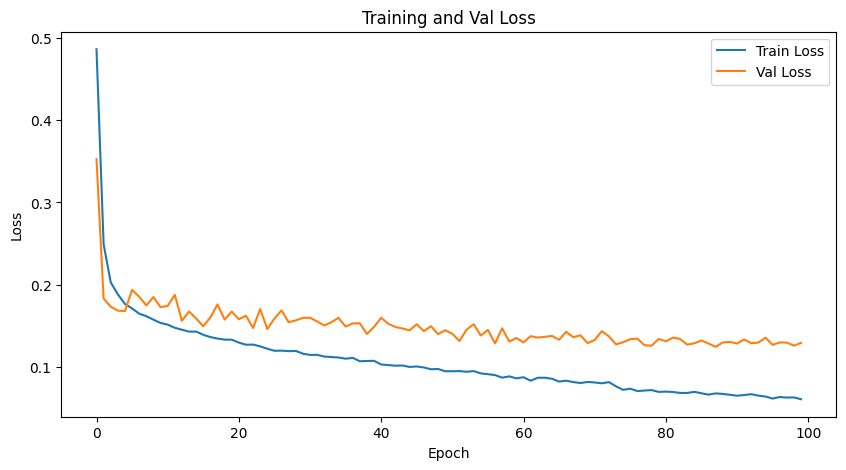

In [23]:
best_model_path = training(model, train_loader, test_loader, device, weighted_mse_loss, epochs=100)

# Load the best model
# model.load_state_dict(torch.load(best_model_path))

In [24]:
def visualize_predictions(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu', n=5):
    import matplotlib.pyplot as plt
    model.eval()
    model.to(device)

    shown = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            for i in range(min(n, images.size(0))):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                true = labels[i].cpu().numpy()
                pred = outputs[i].cpu().numpy()
                
                plt.imshow((img * 0.229 + 0.485))  # unnormalize roughly
                plt.title(f"GT: {true.round(2)} | Pred: {pred.round(2)}")
                plt.axis("off")
                plt.show()

                shown += 1
                if shown >= n:
                    return


C:\Users\mary9\AppData\Local\Temp\ipykernel_26852\1435835549.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
Clipping 

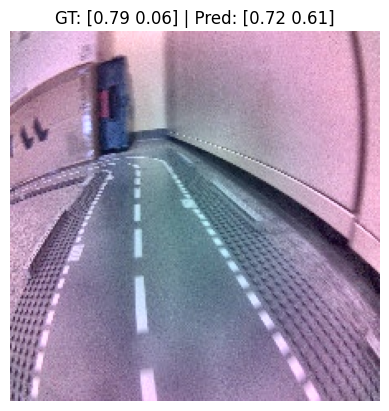

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


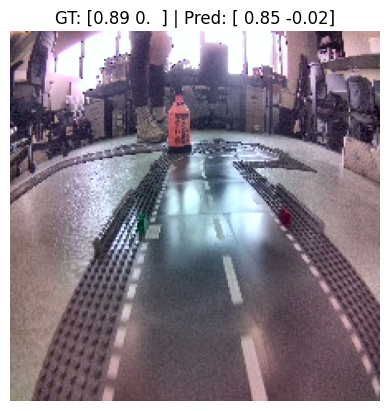

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


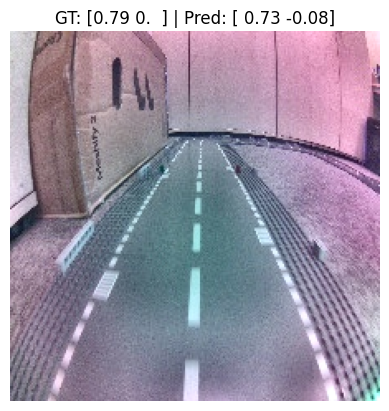

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


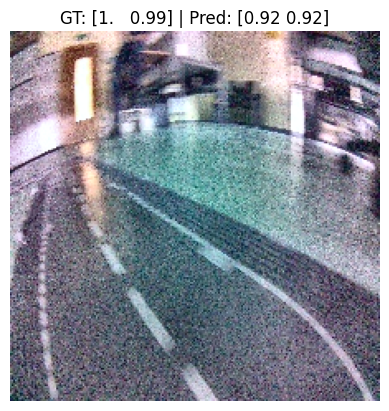

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


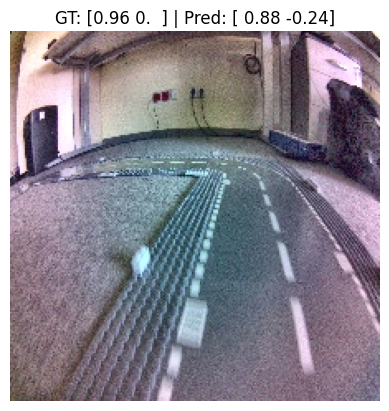

In [25]:
model.load_state_dict(torch.load(best_model_path))

visualize_predictions(model, test_loader)


In [26]:
import matplotlib.pyplot as plt
import torch

def plot_predictions_vs_ground_truth(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu', max_points=500):
    model.eval()
    model.to(device)

    true_left = []
    true_forward = []
    pred_left = []
    pred_forward = []

    with torch.no_grad():
        count = 0
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            # Collect true and predicted values
            true_left.extend(targets[:, 1].cpu().numpy())
            true_forward.extend(targets[:, 0].cpu().numpy())

            # Round predicted left before collecting
            pred_left.extend(outputs[:, 1].cpu().numpy())
            pred_forward.extend(outputs[:, 0].cpu().numpy())

            count += images.size(0)
            if count >= max_points:
                break

    plt.figure(figsize=(8, 8))
    plt.scatter(true_left, true_forward, color='blue', alpha=0.5, label='True')
    plt.scatter(pred_left, pred_forward, color='red', alpha=0.5, label='Predicted ')

    plt.xlabel('Left Value')
    plt.ylabel('Forward Value')
    plt.title('True vs Predicted: Left vs Forward')
    plt.legend()
    plt.grid(True)
    plt.show()


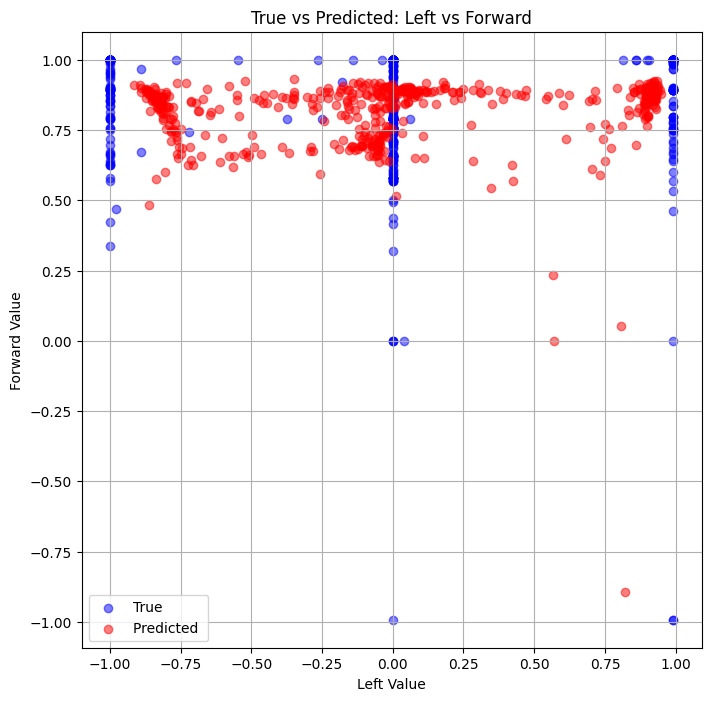

In [27]:
plot_predictions_vs_ground_truth(model, test_loader)


In [28]:
import torch
import onnx

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.eval()
model.to(device)

# Create a dummy input tensor with the same shape as  the model expects
dummy_input = torch.randn(1, 3, 224, 224, device=device)  # batch size 1

onnx_model_path = "model_jetbot.onnx"

torch.onnx.export(
    model,                   # model being run
    dummy_input,             # model input (or a tuple for multiple inputs)
    onnx_model_path,         # where to save the model
    opset_version=11,        # ONNX version
    input_names=['input'],   # input layer names
    output_names=['output'], # output layer names
    dynamic_axes={
        'input': {0: 'batch_size'},    # variable length axes
        'output': {0: 'batch_size'}
    },
    do_constant_folding=True,  # optimization
    verbose=False              # set to True if you want detailed export log
)

# Load and check the ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

print("Model has been successfully exported to ONNX format!")


Model has been successfully exported to ONNX format!


In [29]:
import cv2
import numpy as np
import onnxruntime as rt
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


class AI:
    def __init__(self, model_path: str):
        # self.sess = rt.InferenceSession(model_path, providers=[
        #     'TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

        self.input_name = self.sess.get_inputs()[0].name
        self.output_name = self.sess.get_outputs()[0].name

        # Define same preprocessing used in training
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  # Convert numpy to PIL
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # Convert to tensor and rescale to [0, 1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def preprocess(self, img: np.ndarray) -> np.ndarray:
        """a
        Preprocess BGR image to match model input.
        Converts BGR to RGB, applies resizing, normalization, etc.
        Returns a numpy array of shape (1, 3, 224, 224) with dtype float32.
        """
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = self.transform(img_rgb)  # Apply transforms
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
        return img_tensor.numpy().astype(np.float32)

    def postprocess(self, detections: np.ndarray) -> np.ndarray:
        """
        Postprocess model outputs.
        Converts to 1D numpy array if needed.
        """
        return detections.squeeze()  # Should be shape (2,)

    def predict(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)

        assert inputs.dtype == np.float32
        assert inputs.shape == (1, 3, 224, 224)

        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        outputs = self.postprocess(detections)

        assert outputs.dtype == np.float32
        assert outputs.shape == (2,)
        assert outputs.max() < 1.0
        assert outputs.min() > -1.0

        return outputs


def check(img_name, model):
    image_path = f'camera/{img_name}.png'
    image = cv2.imread(image_path)
    if image is None:
        image_path = f'camera/{img_name}.jpg'
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image '{img_name}' not found in camera/ directory!")

    # model_path = 'model_jetbot.onnx'
    # model.load_state_dict(torch.load(best_model_path))

    # ai = AI(model_path)
    model 
    prediction = ai.predict(image)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Prediction: forward={prediction[0]:.3f}, left={prediction[1]:.3f}")
    plt.show()

In [30]:
def visualize_predictions(model, img, device='cuda' if torch.cuda.is_available() else 'cpu', n=5):
    import matplotlib.pyplot as plt
    model.eval()
    model.to(device)

    shown = 0
    with torch.no_grad():
        images = img.to(device)
        outputs = model(images)
        
        for i in range(min(n, images.size(0))):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            pred = outputs[i].cpu().numpy()
            
            plt.imshow((img * 0.229 + 0.485))  # unnormalize roughly
            plt.title(f" Pred: {pred.round(2)}")
            plt.axis("off")
            plt.show()

            shown += 1
            if shown >= n:
                return


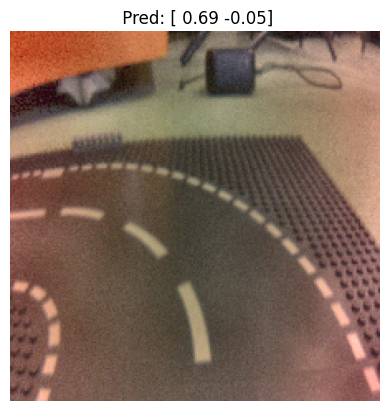

In [31]:
import cv2
import torch
from torchvision import transforms
from PIL import Image

# Load image
image_path = 'camera/2.png'
image = cv2.imread(image_path)
if image is None:
    image_path = 'camera/1.jpg'
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found in camera/ directory!")

# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to PIL Image
image = Image.fromarray(image)

# Preprocess
preprocess = transforms.Compose([
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize((224, 224)),  # adjust size to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

tensor_img = preprocess(image).unsqueeze(0)  # shape: (1, C, H, W)

# Visualize predictions
visualize_predictions(model, tensor_img)
